In [24]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.ensemble import IsolationForest
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler

# Define stock symbols & date range
stocks = ['META', 'MSFT', 'XOM', '^GSPC']
start_date = '2013-01-01'
end_date = '2024-12-31'

# Fetch stock data
data = yf.download(stocks, start=start_date, end=end_date)

# Extract only 'Close' prices to avoid MultiIndex issues
data = data.xs('Close', level=0, axis=1)

# Compute log returns
data_returns = np.log(data / data.shift(1)).dropna()

[*********************100%***********************]  4 of 4 completed


In [25]:
# Define major market events
events = pd.DataFrame({
    'Date': pd.to_datetime([
        '2015-08-24',  # China Market Crash
        '2016-06-24',  # Brexit Vote
        '2018-10-10',  # Market Correction
        '2020-03-16',  # COVID-19 Crash
        '2021-01-27',  # GameStop Short Squeeze
        '2021-11-10',  # Inflation Surge Start
        '2022-12-14',  # Inflation Cooldown
        '2018-12-19',  # Fed Rate Hike
        '2019-07-31',  # Fed Rate Cut
        '2019-08-05',  # US-China Trade War'
    ]),
    'Event': [
        'China Market Crash',
        'Brexit Vote',
        'Market Correction',
        'COVID-19 Crash',
        'GameStop Short Squeeze',
        'Inflation Surge Start',
        'Inflation Cooldown',
        'Fed Rate Hike',
        'Fed Rate Cut',
        'US-China Trade War'
    ]
}).set_index('Date')

# Display event list
print(events)

                             Event
Date                              
2015-08-24      China Market Crash
2016-06-24             Brexit Vote
2018-10-10       Market Correction
2020-03-16          COVID-19 Crash
2021-01-27  GameStop Short Squeeze
2021-11-10   Inflation Surge Start
2022-12-14      Inflation Cooldown
2018-12-19           Fed Rate Hike
2019-07-31            Fed Rate Cut
2019-08-05      US-China Trade War


In [26]:
# Define event window (days before & after)
window = 60

# Initialize dictionaries for storing results
volatility_changes = {}
mean_return_changes = {}
correlation_shifts = {}
t_test_results = {}

for event_date in events.index:
    # Define pre-event and post-event windows
    pre_event = data_returns.loc[:event_date].iloc[-window:]
    post_event = data_returns.loc[event_date:].iloc[:window]

    # Compute rolling volatility
    volatility_before = pre_event.std()
    volatility_after = post_event.std()
    volatility_changes[events.loc[event_date, 'Event']] = (volatility_before, volatility_after)

    # Compute mean returns before and after event
    mean_returns_before = pre_event.mean()
    mean_returns_after = post_event.mean()
    mean_return_changes[events.loc[event_date, 'Event']] = (mean_returns_before, mean_returns_after)

    # Perform t-test to check statistical significance of return changes
    t_stat, p_value = ttest_ind(pre_event, post_event, nan_policy='omit', equal_var=False)
    t_test_results[events.loc[event_date, 'Event']] = (t_stat, p_value)

    # Compute correlation shifts before and after event
    correlation_shifts[events.loc[event_date, 'Event']] = (pre_event.corr(), post_event.corr())

# Display a sample of computed volatility changes
print(pd.DataFrame(volatility_changes).T)

                                                                        0  \
China Market Crash      Ticker
META     0.018819
MSFT     0.014092
XOM...   
Brexit Vote             Ticker
META     0.014496
MSFT     0.015633
XOM...   
Market Correction       Ticker
META     0.031071
MSFT     0.013090
XOM...   
COVID-19 Crash          Ticker
META     0.035150
MSFT     0.039177
XOM...   
GameStop Short Squeeze  Ticker
META     0.022763
MSFT     0.015161
XOM...   
Inflation Surge Start   Ticker
META     0.017833
MSFT     0.012794
XOM...   
Inflation Cooldown      Ticker
META     0.049148
MSFT     0.025658
XOM...   
Fed Rate Hike           Ticker
META     0.023529
MSFT     0.022202
XOM...   
Fed Rate Cut            Ticker
META     0.018361
MSFT     0.012961
XOM...   
US-China Trade War      Ticker
META     0.019031
MSFT     0.013627
XOM...   

                                                                        1  
China Market Crash      Ticker
META     0.019423
MSFT     0.020510
XOM...  


In [27]:
# Standardize stock returns for anomaly detection
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(data_returns)

# Apply Isolation Forest to detect anomalies
iso_forest = IsolationForest(contamination=0.01, random_state=42)
anomaly_labels = iso_forest.fit_predict(scaled_returns)

# Extract anomaly dates
anomaly_dates = data_returns.index[anomaly_labels == -1]

# Print detected anomalies
print(f"Anomalies detected on {len(anomaly_dates)} days!")
print(anomaly_dates[:10])  # Display first 10 anomaly dates

Anomalies detected on 31 days!
DatetimeIndex(['2015-08-26', '2018-02-05', '2018-12-26', '2020-02-24',
               '2020-02-27', '2020-03-02', '2020-03-03', '2020-03-09',
               '2020-03-10', '2020-03-11'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [28]:
# Check what kind of data exists in volatility_changes
sample_event = list(volatility_changes.keys())[0]  # Get a random event key
print(f"Sample Event: {sample_event}")
print(f"Sample Data:\n{volatility_changes[sample_event]}")

Sample Event: China Market Crash
Sample Data:
(Ticker
META     0.018819
MSFT     0.014092
XOM      0.013838
^GSPC    0.009754
dtype: float64, Ticker
META     0.019423
MSFT     0.020510
XOM      0.018185
^GSPC    0.013265
dtype: float64)


<Figure size 1200x600 with 0 Axes>

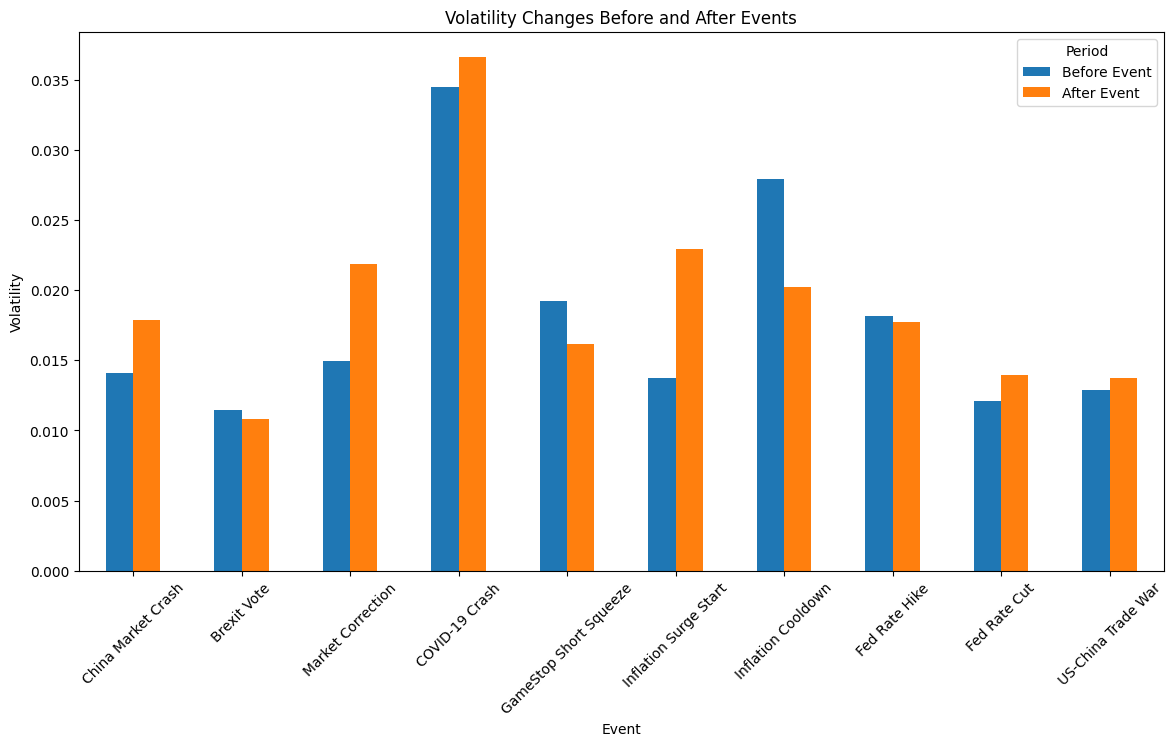

In [29]:
# Convert dictionary to DataFrame
volatility_df = pd.DataFrame.from_dict(volatility_changes, orient='index')

# Extract "Before" and "After" columns
volatility_df.columns = ['Before Event', 'After Event']

# Ensure numeric format by taking mean across stocks
volatility_df = volatility_df.map(lambda x: x.mean() if isinstance(x, pd.Series) else x)

# Drop NaN rows
volatility_df.dropna(inplace=True)

# Check if DataFrame is empty before plotting
if volatility_df.empty:
    print("Error: Volatility DataFrame is empty! Check calculations.")
else:
    # Reset index for proper plotting
    volatility_df.reset_index(inplace=True)
    volatility_df.rename(columns={"index": "Event"}, inplace=True)

    # Plot improved volatility changes
    plt.figure(figsize=(12, 6))
    volatility_df.set_index("Event").plot(kind='bar', figsize=(14, 7))
    plt.title("Volatility Changes Before and After Events")
    plt.ylabel("Volatility")
    plt.xlabel("Event")
    plt.xticks(rotation=45)
    plt.legend(title='Period')
    plt.show()

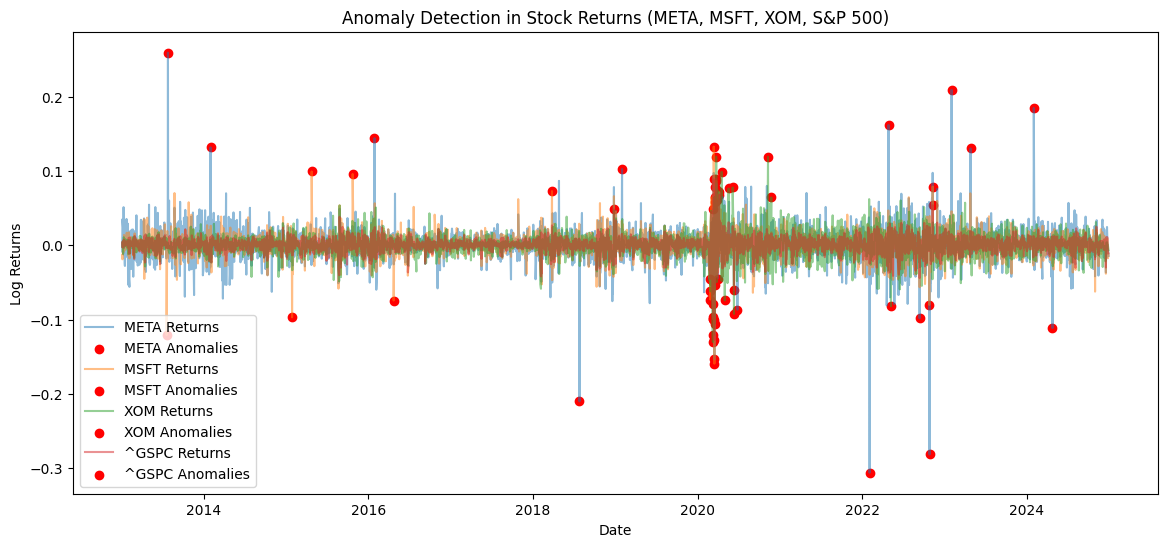

META: 16 anomalies detected!
MSFT: 15 anomalies detected!
XOM: 16 anomalies detected!
^GSPC: 16 anomalies detected!


In [30]:
from sklearn.ensemble import IsolationForest

# Adjusted contamination level for more refined anomaly detection
iso_forest = IsolationForest(contamination=0.005, random_state=42)

# Dictionary to store anomaly dates for each stock
anomaly_dict = {}

# Detect anomalies for each stock
plt.figure(figsize=(14, 6))
for stock in ['META', 'MSFT', 'XOM', '^GSPC']:
    # Compute rolling volatility (30-day window)
    rolling_volatility = data_returns[stock].rolling(window=30).std()

    # Fit Isolation Forest to detect anomalies
    iso_forest.fit(data_returns[[stock]])
    anomaly_labels = iso_forest.predict(data_returns[[stock]])

    # Identify anomaly dates
    anomaly_dates = data_returns.index[anomaly_labels == -1]
    anomaly_dict[stock] = anomaly_dates

    # Plot stock returns with rolling volatility as background
    plt.plot(data_returns.index, data_returns[stock], label=f"{stock} Returns", alpha=0.5)

    # Scatter plot anomalies in red
    plt.scatter(anomaly_dates, data_returns.loc[anomaly_dates, stock], color='red', label=f'{stock} Anomalies', marker='o')

plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.title("Anomaly Detection in Stock Returns (META, MSFT, XOM, S&P 500)")
plt.legend()
plt.show()

# Print the number of detected anomalies for each stock
for stock, anomalies in anomaly_dict.items():
    print(f"{stock}: {len(anomalies)} anomalies detected!")


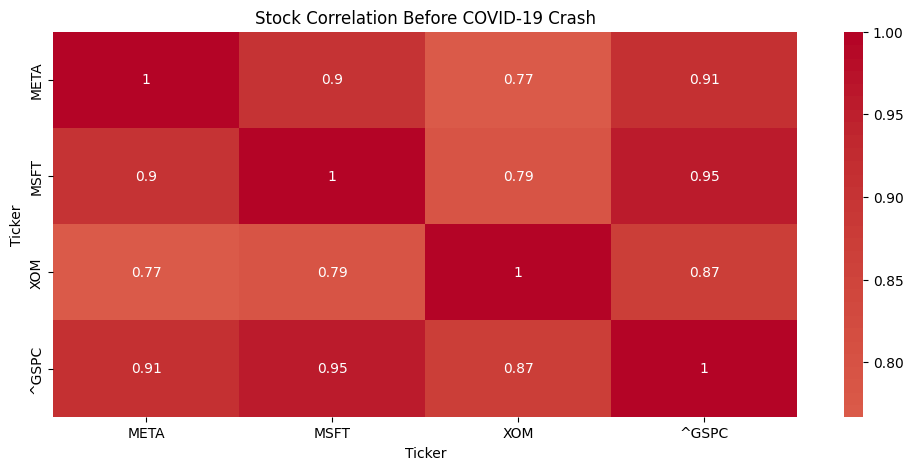

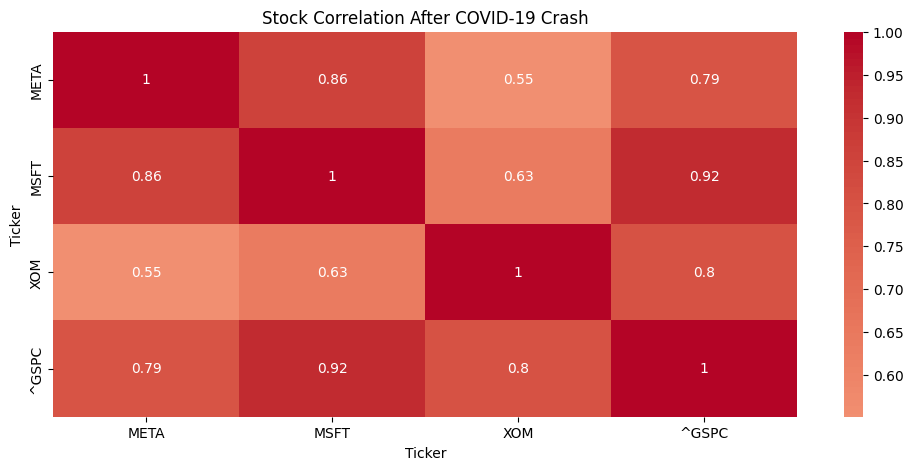

In [31]:
# Display correlation matrix before & after a specific event (e.g., COVID-19 Crash)
corr_before, corr_after = correlation_shifts['COVID-19 Crash']

plt.figure(figsize=(12, 5))
sns.heatmap(corr_before, annot=True, cmap='coolwarm', center=0)
plt.title("Stock Correlation Before COVID-19 Crash")
plt.show()

plt.figure(figsize=(12, 5))
sns.heatmap(corr_after, annot=True, cmap='coolwarm', center=0)
plt.title("Stock Correlation After COVID-19 Crash")
plt.show()


Analyzing Sector Differences: Tech vs. Energy Stocks

Total Anomalies by Sector:
Tech Stocks (META, MSFT): 31
Energy Stocks (XOM): 16
S&P 500: 16


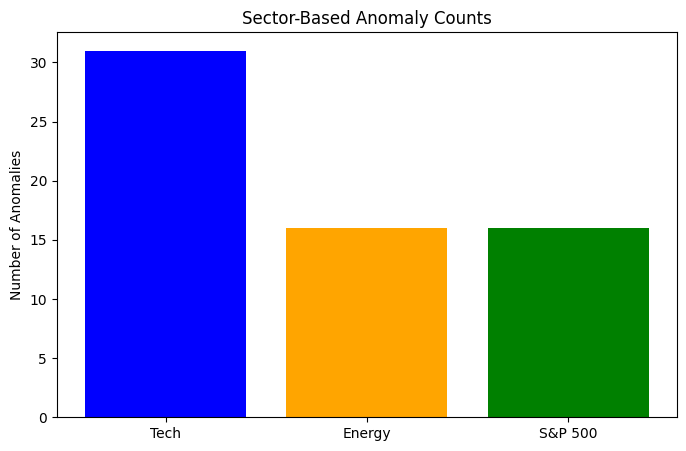

In [32]:
print("\nAnalyzing Sector Differences: Tech vs. Energy Stocks")
tech_stocks = ['META', 'MSFT']
energy_stocks = ['XOM']
market_index = ['^GSPC']

# Count anomalies per sector
tech_anomalies = sum(len(anomaly_dict[stock]) for stock in tech_stocks)
energy_anomalies = sum(len(anomaly_dict[stock]) for stock in energy_stocks)
sp500_anomalies = len(anomaly_dict['^GSPC'])

print(f"\nTotal Anomalies by Sector:")
print(f"Tech Stocks (META, MSFT): {tech_anomalies}")
print(f"Energy Stocks (XOM): {energy_anomalies}")
print(f"S&P 500: {sp500_anomalies}")

# Plot anomaly counts by sector
plt.figure(figsize=(8, 5))
plt.bar(["Tech", "Energy", "S&P 500"], [tech_anomalies, energy_anomalies, sp500_anomalies], color=['blue', 'orange', 'green'])
plt.title("Sector-Based Anomaly Counts")
plt.ylabel("Number of Anomalies")
plt.show()

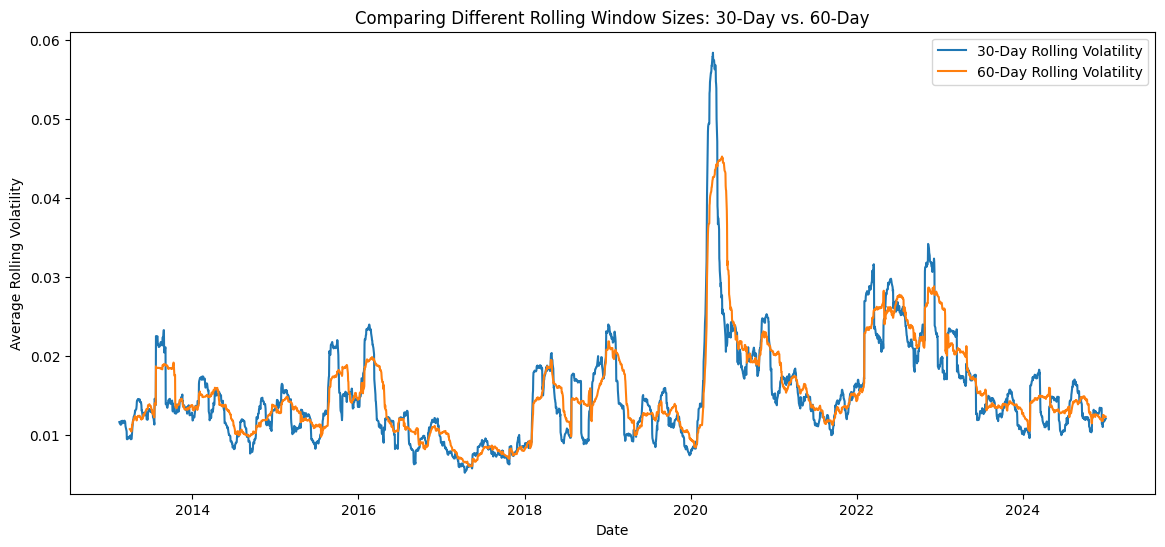

In [33]:
rolling_windows = [30, 60]  # Test different rolling windows
rolling_results = {}

for window in rolling_windows:
    rolling_vol_dict = {stock: data_returns[stock].rolling(window=window).std() for stock in stocks}
    rolling_results[window] = pd.DataFrame(rolling_vol_dict)

# Plot rolling volatility for comparison
plt.figure(figsize=(14, 6))
for window, df in rolling_results.items():
    plt.plot(df.index, df.mean(axis=1), label=f"{window}-Day Rolling Volatility")

plt.xlabel("Date")
plt.ylabel("Average Rolling Volatility")
plt.title("Comparing Different Rolling Window Sizes: 30-Day vs. 60-Day")
plt.legend()
plt.show()


Average Log Returns 5 Days After Anomalies:
META: 0.01493
MSFT: -0.00325
XOM: -0.00362
^GSPC: -0.00931


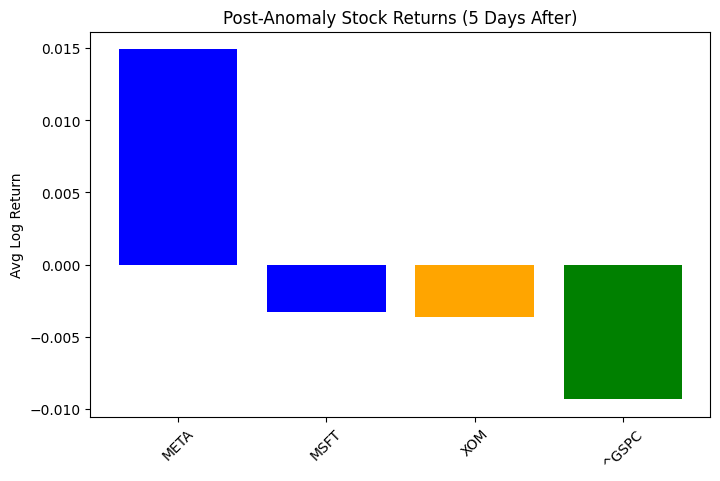

In [34]:
# Define how many days after an anomaly to track
days_after = 5
post_anomaly_returns = {}

for stock in stocks:
    anomaly_dates = anomaly_dict[stock]

    avg_returns = []
    for date in anomaly_dates:
        future_date = date + pd.Timedelta(days=days_after)
        if future_date in data_returns.index:
            future_return = data_returns.loc[future_date, stock]
            avg_returns.append(future_return)

    post_anomaly_returns[stock] = np.mean(avg_returns) if avg_returns else None

print("\nAverage Log Returns 5 Days After Anomalies:")
for stock, avg_return in post_anomaly_returns.items():
    print(f"{stock}: {avg_return:.5f}")

# Plot post-anomaly return behavior
plt.figure(figsize=(8, 5))
plt.bar(stocks, [post_anomaly_returns[stock] for stock in stocks], color=['blue', 'blue', 'orange', 'green'])
plt.title("Post-Anomaly Stock Returns (5 Days After)")
plt.ylabel("Avg Log Return")
plt.xticks(rotation=45)
plt.show()